In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from matplotlib import rc
import os
rc('font',**{'family':'serif','serif':['mathtime']})
rc('text', usetex=True)

# Preliminaries

`rq1_systems` defines the systems under test

In [2]:
rq1_systems = ["Husky", "AutoRally", "Fetch", "TurtleBot", "Autoware"]
rq1_systems_dict = {"husky" : "Husky", "autorally" : "AutoRally", "fetch":"Fetch", "turtlebot":"TurtleBot", "autoware":"Autoware"}
rq1_systems.sort()
print(rq1_systems)

['AutoRally', 'Autoware', 'Fetch', 'Husky', 'TurtleBot']


In [3]:
def hist(s, height):
    h = s.hist(bins=50,figsize=(8,height),ylabelsize=15,xlabelsize=15, color = "black")
    h.set_frame_on(False)
    return h

In [4]:
def histUnknown(df):
    df_no_crash = df.loc[df['crashed'] == False]
    percent_unknown = df_no_crash["unknown_api_calls"] / df_no_crash["api_calls"] * 100
    return hist(percent_unknown, 3)
    

In [5]:
def histUnknownNZ(df):
    df_no_crash = df.loc[df['crashed'] == False]
    percent_unknown = df_no_crash["unknown_api_calls"] / df_no_crash["api_calls"] * 100
    percent_unknown_no_0 = percent_unknown[percent_unknown > 0]    
    return hist(percent_unknown_no_0,1.5)

# RQ1 How accurately does ROSDiscover statically recover the interface of ROS nodes?

In [6]:
# Reads the data from the aggreation of the nodel-level analysis scrips
def getRQ1Data(name):
    return pd.read_csv(f'data/RQ1 node model recovery results - {name.lower()}.csv')

In [7]:
# Aggregates the data and prints results summaries in human-readable form
def calculateRQ1(df, name):
    df_no_crash = df.loc[df['crashed'] == False]
    nodes = len(df_no_crash)
    print(f'{name} has {nodes} nodes that did not crash')
    crashed_nodes = len(df) - len(df_no_crash) 
    print(f'{name} crashed in {(1 - len(df_no_crash) / len(df)) * 100}% of the cases')
    api_calls = int(df_no_crash["api_calls"].sum())
    
    unknown_percentage = df_no_crash["unknown_api_calls"].sum() / api_calls * 100
    unknown_nodes_number = len(df.loc[df['unknown_api_calls'] > 0])
    unknown_nodes_percentage = unknown_nodes_number / nodes * 100
    
    print(f'{unknown_nodes_percentage}% of the nodes have at least one unknown API call')
    avg_time_taken = sum(df_no_crash['time_taken']) / len(df_no_crash['time_taken'])
    
    print(f'{name} got {unknown_percentage}% unknowns for API calls (of {api_calls})')
    unreachable_functions = int(df_no_crash["unreachable_functions"].sum())
    unreachable_api_calls = int(df_no_crash["unreachable_api_calls"].sum())
    functions = int(df_no_crash["functions"].sum())
    print(f'{name} has {unreachable_functions} unreachable functions (of {functions}) and {unreachable_api_calls} unreachable API calls')
    df_no_crash["unknown_api_calls"].sum()
    
    return crashed_nodes, unknown_percentage, api_calls, unreachable_functions, unreachable_api_calls, unknown_nodes_number, unknown_nodes_percentage, nodes, functions, avg_time_taken

In [8]:
# Process the data for one system to create csv file
def processRQ1data(df, name, csv_content, csv_content_, csv_content_2):    
    crashed_nodes, unknown_percentage,api_calls, unreachable_functions,unreachable_api_calls,unknown_nodes_number, unknown_nodes_percentage,nodes,functions,avg_time_taken = calculateRQ1(df, name)
    unreachable_api_calls_percentage = unreachable_api_calls / api_calls * 100
    unreachable_functions_percentage = unreachable_functions / functions * 100
    csv_content += f'{name},{api_calls},{unknown_percentage},{unreachable_functions},{unreachable_api_calls}\n'
    csv_content_ += f'{name},{api_calls},{unknown_percentage},{nodes},{unknown_nodes_percentage}\n'
    csv_content_2 += f'{name},{api_calls},{unknown_percentage},{unreachable_functions_percentage:.2f}\% of {functions},{unreachable_api_calls_percentage}\n'
    return csv_content, csv_content_, csv_content_2

In [9]:
csv_content= "System,API Calls,Percent of Unknown API Calls,Unreachable Functions,Unreachable API Calls\n"
csv_content_= "System,API Calls,Percent of Unknown API Calls,Nodes,Percent of Unknown Nodes\n"
csv_content_2= "System,API Calls,Percent of Unknown API Calls,Nodes,Percent of Unknown Nodes\n"

all_dfs = []
for name in rq1_systems:
    df = getRQ1Data(name)
    all_dfs.append(df)
    csv_content, csv_content_, csv_content_2 = processRQ1data(df, name, csv_content, csv_content_, csv_content_2)

df_all = pd.concat(all_dfs).drop_duplicates(subset=['package','node'])
csv_content, csv_content_, csv_content_2 = processRQ1data(df_all, "All", csv_content, csv_content_, csv_content_2)
    
with open('data\RQ1A.csv', 'w') as file:
    file.write(csv_content)    
    
with open('data\RQ1Along.csv', 'w') as file:
    file.write(csv_content_)        

with open('data\RQ1Percent.csv', 'w') as file:
    file.write(csv_content_2)            
if not os.path.isdir("images"):
    os.makedirs("images")
pd.read_csv("data\RQ1Along.csv")


AutoRally has 25 nodes that did not crash
AutoRally crashed in 3.8461538461538436% of the cases
16.0% of the nodes have at least one unknown API call
AutoRally got 13.333333333333334% unknowns for API calls (of 75)
AutoRally has 4 unreachable functions (of 44) and 10 unreachable API calls
Autoware has 205 nodes that did not crash
Autoware crashed in 10.869565217391308% of the cases
31.70731707317073% of the nodes have at least one unknown API call
Autoware got 14.729574223245109% unknowns for API calls (of 869)
Autoware has 50 unreachable functions (of 354) and 74 unreachable API calls
Fetch has 93 nodes that did not crash
Fetch crashed in 1.0638297872340385% of the cases
1.0752688172043012% of the nodes have at least one unknown API call
Fetch got 1.9417475728155338% unknowns for API calls (of 103)
Fetch has 3 unreachable functions (of 123) and 7 unreachable API calls
Husky has 105 nodes that did not crash
Husky crashed in 4.545454545454541% of the cases
2.857142857142857% of the node

,System,API Calls,Percent of Unknown API Calls,Nodes,Percent of Unknown Nodes
0,AutoRally,75,13.333333,25,16.000000
1,Autoware,869,14.729574,205,31.707317
2,Fetch,103,1.941748,93,1.075269
3,Husky,225,2.666667,105,2.857143
4,TurtleBot,158,17.721519,105,2.857143
5,All,1321,13.171840,504,15.079365


Accuracy of static node recovery per system. Unknown API calls are architecturally relevant ROS API calls for which the static recovery cannot resolve all arguments. "All" describes the union of all nodes, hence includes reused nodes only once.

### The historgram of frequencies of API call unknown percentages per node

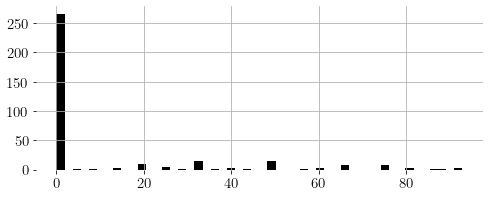

In [10]:
histUnknown(df_all).figure.savefig('images/RQ1Hist.pdf', bbox_inches='tight')

### The historgram of frequencies of API call unknown percentages per node (for those that are non zero)

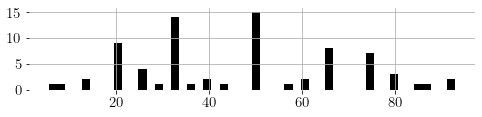

In [11]:
plt.clf()
histUnknownNZ(df_all).figure.savefig('images/RQ1Hist_nz.pdf', bbox_inches='tight')

# RQ2 - How accurately does ROSDiscover statically recover run-time architectures of real ROS systems?

In [12]:
df_observed = pd.read_csv(f'data/RQ2 Observed Architecture - Summary.csv',index_col="Subject").drop(columns=["Case"])
df_observed

,#Nodes,#Topics,#Services,#Actions,#Errors
Subject,,,,,
Autorally,11,101,63.0,0,6
Fetch (Pick in place),10,188,94.0,12,3
Fetch (Move and pick),15,16,NaN,10,2
Husky,12,53,53.0,0,3
Turtlebot,13,100,59.0,1,5


The number of architectural elements observed using dynamic execution of an architectural configuration 

In [13]:
rq2_columnremap = {'# observed':'observed', '# recovered':'recovered', "# obs ! rec":"obs not rec", "# rec ! obs":"rec not obs", "over_approx":"overapprox", "under_approx":"underapprox"}
rq2_headers = ["observed", "recovered", "overapprox", "underapprox"]

In [14]:
def to_percent(d):
    return (d * 100) 
def over_approx(x):
    if x['observed'] == 0:
        return 0
    else:
        return to_percent(x['rec not obs'] / x['observed'])

def under_approx(x):
    if x['observed'] == 0:
        return 0
    else:
        return to_percent(x['obs not rec'] / x['observed'])

In [15]:
def process_df_rq2(df):
    df['overapprox'] = df.apply(lambda x: over_approx(x), axis=1)
    df['underapprox'] = df.apply(lambda x: under_approx(x), axis=1)
    return df


In [16]:
#Reading the raw data

df_rq2_all = pd.read_csv(f'data/RQ2 Observed Architecture - Node-Level Comparison.csv')
df_rq2_all = df_rq2_all.fillna(0)
df_rq2_all = df_rq2_all[df_rq2_all["Subject"] != 0].copy()

df_rq2_all.rename(columns = rq2_columnremap, inplace = True)
df_rq2 = df_rq2_all[df_rq2_all["Case"] == "recovered"].groupby(by=["Subject", "Kind"], as_index=False).sum()
df_rq2 = process_df_rq2(df_rq2)
df_rq2

,Subject,Kind,observed,recovered,obs not rec,rec not obs,overapprox,underapprox,# errs observed,# errors recovered,#handwritten,#recovered,# placeholders
0,AutoRally,Action Clients,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,AutoRally,Action Servers,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,AutoRally,Providers,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,AutoRally,Publishers,6.0,6.0,0.0,0.0,0.000000,0.000000,6.0,8.0,8.0,4.0,0.0
4,AutoRally,Subscribers,7.0,7.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,Husky,Action Clients,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
6,Husky,Action Servers,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
7,Husky,Providers,4.0,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
8,Husky,Publishers,7.0,6.0,2.0,1.0,14.285714,28.571429,2.0,5.0,8.0,4.0,0.0
9,Husky,Subscribers,4.0,3.0,1.0,0.0,0.000000,25.000000,0.0,0.0,0.0,0.0,0.0


### Hand-written models

In [17]:
df_rq2_hw_all = pd.read_csv(f'data/RQ2 Observed Architecture - Comparison.csv')
df_rq2_hw_all = df_rq2_hw_all.fillna(0)
df_rq2_hw_all.rename(columns = rq2_columnremap, inplace = True)
df_rq2_hw_all = df_rq2_hw_all[df_rq2_hw_all["Subject"] != 0].copy()[df_rq2_hw_all["Case"] == "handwritten"]
df_rq2_hw = df_rq2_hw_all.groupby(by="Subject", as_index=False).sum()

df_rq2_hw = process_df_rq2(df_rq2_hw)


<ipython-input-17-808d5b0c84b5>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rq2_hw_all = df_rq2_hw_all[df_rq2_hw_all["Subject"] != 0].copy()[df_rq2_hw_all["Case"] == "handwritten"]


In [18]:
df_rq2_hw_all.groupby(by=["Subject"]).sum()

,observed,recovered,obs not rec,rec not obs,overapprox,underapprox,# errs observed,# errors recovered,#handwritten,#recovered,# placeholders
Subject,,,,,,,,,,,
AutoRally,99.0,101.0,0.0,2.0,0.070505,0.000000,0.0,0.0,0.0,0.0,0.0
Husky,64.0,81.0,6.0,23.0,1.423077,0.314103,0.0,0.0,0.0,0.0,0.0
TurtleBot,76.0,72.0,6.0,2.0,0.109181,0.282878,0.0,0.0,0.0,0.0,0.0


In [19]:
df_rq2_hw

,Subject,observed,recovered,obs not rec,rec not obs,overapprox,underapprox,# errs observed,# errors recovered,#handwritten,#recovered,# placeholders
0,AutoRally,99.0,101.0,0.0,2.0,2.020202,0.000000,0.0,0.0,0.0,0.0,0.0
1,Husky,64.0,81.0,6.0,23.0,35.937500,9.375000,0.0,0.0,0.0,0.0,0.0
2,TurtleBot,76.0,72.0,6.0,2.0,2.631579,7.894737,0.0,0.0,0.0,0.0,0.0


In [20]:
df_rq2_hw_agg = df_rq2_hw_all.groupby(by=["Kind"], as_index=False).sum()
df_rq2_hw_agg = process_df_rq2(df_rq2_hw_agg)
df_rq2_hw_agg['Subject'] = "All" 
df_rq2_hw_merge = pd.concat([df_rq2_hw, df_rq2_hw_agg.groupby(by=["Subject"], as_index=False).sum()])
df_rq2_hw_merge = process_df_rq2(df_rq2_hw_merge)

df_rq2_hw_merge.to_csv('data/RQ2Agghw.csv', index = False, columns=["Subject"]+rq2_headers)
df_rq2_hw_agg.drop(df_rq2_hw_agg[df_rq2_hw_agg.Kind == "Nodes"].index).to_csv('data/RQ2Kindhw.csv', index = False, columns=["Kind"]+rq2_headers)

In [21]:
df_rq2_models = pd.read_csv(f'data/RQ2 Observed Architecture - Models.csv')
df_rq2_models.fillna('',inplace=True)
df_rq2_models = df_rq2_models.drop_duplicates(subset=['Handwritten Node'])
df_rq2_models

,Handwritten Node,Type,Kind,Reason Used
0,spawn_turtlebot_model,spawner,Simulation,Loads robot model
1,gazebo_gui,,Simulation,
2,robot_state_publisher,,Core,Clang parsing issue
3,gazebo,,Simulation,
4,cmd_vel_mux,,Core,Reads interfaces from configuration parameters
5,move_base,,Core,Plugin architecture
6,spawn_platform,spawner,Simulation,Loads Gazebo Plugins
8,autorally_state_publisher,,Simulation,Python
10,autorally_controller,,Simulation,Python
11,ground_truth_republisher,,Simulation,Python


In [22]:
handwritten_models_total = len(df_rq2_models["Handwritten Node"])
handwritten_models_core = len(df_rq2_models[df_rq2_models["Kind"] == "Core"])
handwritten_models_simulation = len(df_rq2_models[df_rq2_models["Kind"] == "Simulation"])
handwritten_models_python = len(df_rq2_models[df_rq2_models["Reason Used"] == "Python"])
df_rq2_all

,Subject,Node,Case,Kind,observed,recovered,obs not rec,rec not obs,overapprox,underapprox,# errs observed,# errors recovered,overlap matches,#handwritten,#recovered,# placeholders
1,AutoRally,/joy_node,recovered,Publishers,1.0,1.0,0.0,0.0,0.0,0.000000,6.0,8.0,False,8.0,4.0,0.0
2,AutoRally,/joy_node,recovered,Subscribers,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0
3,AutoRally,/joy_node,recovered,Providers,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0
4,AutoRally,/joy_node,recovered,Action Clients,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0
5,AutoRally,/joy_node,recovered,Action Servers,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0
6,AutoRally,/autorally_core_manager,recovered,Publishers,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0
7,AutoRally,/autorally_core_manager,recovered,Subscribers,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0
8,AutoRally,/autorally_core_manager,recovered,Providers,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0
9,AutoRally,/autorally_core_manager,recovered,Action Clients,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0
10,AutoRally,/autorally_core_manager,recovered,Action Servers,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0


In [23]:
df_rq2_agg = df_rq2_all.groupby(by=["Kind"], as_index=False).sum()
df_rq2_agg = process_df_rq2(df_rq2_agg)
df_rq2_agg['Subject'] = "All" 
df_rq2_agg.to_csv('data/RQ2Kind.csv', index = False, columns=["Kind"] + rq2_headers)
df_rq2_agg

,Kind,observed,recovered,obs not rec,rec not obs,overapprox,underapprox,# errs observed,# errors recovered,#handwritten,#recovered,# placeholders,Subject
0,Action Clients,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,All
1,Action Servers,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,All
2,Providers,8.0,8.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,All
3,Publishers,18.0,18.0,2.0,2.0,11.111111,11.111111,10.0,15.0,24.0,12.0,0.0,All
4,Subscribers,14.0,13.0,2.0,1.0,7.142857,14.285714,0.0,0.0,0.0,0.0,0.0,All


Accuracy of static recovery (for AutoRally, Husky, and TurtleBot) per architectural element

In [24]:
df_rq2_merge = pd.concat([df_rq2, df_rq2_agg])
df_rq2_merge = df_rq2_merge.groupby(by=["Subject"], as_index=False).sum()
df_rq2_merge = process_df_rq2(df_rq2_merge)
df_rq2_merge.to_csv('data/RQ2All.csv', index = False)

In [25]:
rq2_subjects = list(set(df_rq2["Subject"]))
rq2_subjects.sort()
rq2_subjects_ = rq2_subjects+["All"]

### System-level accuracy of the static recovery

In [26]:
df_rq_all = df_rq2_merge.groupby(by="Subject").sum()
df_rq_all['overapprox'] = df_rq_all.apply(lambda x: over_approx(x), axis=1)
df_rq_all['underapprox'] = df_rq_all.apply(lambda x: under_approx(x), axis=1)
df_rq_all = df_rq_all.reindex(rq2_subjects+["All"])
df_rq_all.to_csv('data/RQ2Agg.csv', index = True, columns=rq2_headers )
df_rq_all

,observed,recovered,obs not rec,rec not obs,overapprox,underapprox,# errs observed,# errors recovered,#handwritten,#recovered,# placeholders
Subject,,,,,,,,,,,
AutoRally,13.0,13.0,0.0,0.0,0.000000,0.000000,6.0,8.0,8.0,4.0,0.0
Husky,15.0,13.0,3.0,1.0,6.666667,20.000000,2.0,5.0,8.0,4.0,0.0
TurtleBot,12.0,13.0,1.0,2.0,16.666667,8.333333,2.0,2.0,8.0,4.0,0.0
All,40.0,39.0,4.0,3.0,7.500000,10.000000,10.0,15.0,24.0,12.0,0.0


Accuracy of static recovery per system. Observed and recovered contains publishers, subscribers, service providers, and  action servers. Our systems do not use action clients. "All" contains all configurations, with reused nodes showing up multiple times

In [27]:
print(f"Total handwritten models in experiments: {handwritten_models_total}")
print(f"Total handwritten models in core library: {handwritten_models_core}")
print(f"Total handwritten models for simulation nodes:{handwritten_models_simulation}")
print(f"Total handwritten models for Python nodes: {handwritten_models_python}")

for name in rq2_subjects_:
    overapprox = df_rq_all["overapprox"].iloc[df_rq_all.index == name][name]
    print(f"{name} overapproximation: {overapprox:.3f}")
    underapprox = df_rq_all["underapprox"].iloc[df_rq_all.index == name][name]
    print(f"{name} underapproximation: {underapprox:.3f}")
    handwritten = df_rq_all["#handwritten"].iloc[df_rq_all.index == name][name]
    print(f"Handwritten models for {name}: {int(handwritten)}")
    recovered = df_rq_all["#recovered"].iloc[df_rq_all.index == name][name]
    print(f"Recovered models for {name}: {int(handwritten)}")
    if (name != "All"):
        false_positives = df_rq2_all[df_rq2_all["Subject"] == name]["# errors recovered"].max()    
        print(f"False positives for {name}: {int(false_positives)}")
    
for name in set(df_rq2_agg["Kind"]):
    name_ = name.replace(" ", "")
    overapprox = list(df_rq2_agg[df_rq2_agg["Kind"] == name]["overapprox"])[0]
    print(f"{name} overapproximation: {overapprox:.3f}")
    underapprox = list(df_rq2_agg[df_rq2_agg["Kind"] == name]["underapprox"])[0]
    print(f"{name} underapproximation: {underapprox:.3f}")


Total handwritten models in experiments: 15
Total handwritten models in core library: 4
Total handwritten models for simulation nodes:10
Total handwritten models for Python nodes: 3
AutoRally overapproximation: 0.000
AutoRally underapproximation: 0.000
Handwritten models for AutoRally: 8
Recovered models for AutoRally: 8
False positives for AutoRally: 8
Husky overapproximation: 6.667
Husky underapproximation: 20.000
Handwritten models for Husky: 8
Recovered models for Husky: 8
False positives for Husky: 5
TurtleBot overapproximation: 16.667
TurtleBot underapproximation: 8.333
Handwritten models for TurtleBot: 8
Recovered models for TurtleBot: 8
False positives for TurtleBot: 2
All overapproximation: 7.500
All underapproximation: 10.000
Handwritten models for All: 24
Recovered models for All: 24
Subscribers overapproximation: 7.143
Subscribers underapproximation: 14.286
Providers overapproximation: 0.000
Providers underapproximation: 0.000
Publishers overapproximation: 11.111
Publishers

# RQ3 - How effectively does ROSDiscover find configuration bugs in real ROS systems?

In [28]:
df_rq3 = pd.read_csv(f'data/RosTopicBugs - RQ3 - Results Table.csv').drop(columns=["Github commit message", "Reason for non recovery", "Issue"])
df_rq3.fillna('',inplace=True)
df_rq3 = df_rq3.sort_values(by=['Bug'])
df_rq3

,Bug,in-vivo,in-vitro,in-theory,Description,Long Description,Link
2,autorally-01,,x,,Inconsistent topic names,Rename of publisher /pose_estimate_new instea...,https://github.com/AutoRally/autorally/commit/...
3,autorally-02,,,x,Topic name variable ignored,"Constant ""/pose_estimate"" in code instead of t...",https://github.com/AutoRally/autorally/commit/...
4,autorally-03,,x,,Incorrect topic remapping,The topics camera/left and camera/right were n...,https://github.com/AutoRally/autorally/commit/...
5,autorally-04,,x,,Incorrect topic remapping,The topic image was not remapped correctly to ...,https://github.com/AutoRally/autorally/commit/...
6,autorally-05,,,x,Incorrect parameter path,Parameter path_topic to /mppi_opponent_control...,https://github.com/AutoRally/autorally/commit/...
0,autoware-01,x,,,Inconsistent topic names,Misconfigured topic names: The topics ''point_...,https://github.com/Autoware-AI/autoware.ai/com...
1,autoware-02,,,,Dangling connector,"Dangling connector ""odom_pose"". Can't recover...",https://github.com/Autoware-AI/autoware.ai/com...
7,autoware-03,,,x,Topic name typo,"Node ""velocity_set"" is subscribing to topic ""b...",https://github.com/Autoware-AI/autoware.ai/com...
19,autoware-04,,,,Inconsistent topic names,Can't recover. Topic name uses string manipula...,https://github.com/Autoware-AI/autoware.ai/com...
8,autoware-05,,,x,Inconsistent topic names,"topic name was changed to ""/detection/object_t...",https://github.com/Autoware-AI/autoware.ai/com...


In [29]:
rq3_numBugs = len(df_rq3)
print(f"Number of bugs: {rq3_numBugs}")

detectInVivo = df_rq3["in-vivo"].value_counts()["x"]
print(f"Bugs detected in-vivo: {detectInVivo}")

detectInVitro = df_rq3["in-vitro"].value_counts()["x"]
print(f"Bugs detected using forward- bugs: {detectInVitro}")

detectInVitro = df_rq3["in-vitro"].value_counts()["x"]
numDetected = detectInVivo + detectInVitro
print(f"Bugs detected in total: {numDetected}")

detectInTheory = df_rq3["in-theory"].value_counts()["x"]
print(f"Bugs detectable in theory: {detectInTheory}")

undetectable = len(df_rq3) - detectInVivo - detectInVitro - detectInTheory
print(f"Undetectable bugs: {undetectable}")
    
precision_percent = (numDetected) / rq3_numBugs * 100
print(f"Precision: {round(precision_percent)}%")

precision_incl_theory_percent = (numDetected  + detectInTheory) / rq3_numBugs * 100
print(f"Precision incl. in-theory: {round(precision_incl_theory_percent)}%")

Number of bugs: 20
Bugs detected in-vivo: 2
Bugs detected using forward- bugs: 6
Bugs detected in total: 8
Bugs detectable in theory: 8
Undetectable bugs: 4
Precision: 40%
Precision incl. in-theory: 80%
